In [1]:
import kagglehub
path = kagglehub.dataset_download("shalmamuji/personality-prediction-data-introvert-extrovert")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/personality-prediction-data-introvert-extrovert


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import tensorflow as tf
from tensorflow.keras import layers, models

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import warnings
warnings.filterwarnings("ignore")

/kaggle/input/personality-prediction-data-introvert-extrovert/personality_dataset.xlsx
/kaggle/input/personality-prediction-data-introvert-extrovert/personality_dataset.csv


In [23]:
data = pd.read_csv('/kaggle/input/personality-prediction-data-introvert-extrovert/personality_dataset.csv')
data.head()

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,3,Yes,6,7,No,14,5,Extrovert
1,2,No,8,6,No,7,8,Extrovert
2,1,No,9,4,No,9,3,Extrovert
3,8,No,0,0,Yes,9,3,Introvert
4,5,Yes,3,0,No,2,6,Introvert


In [24]:
le = LabelEncoder()
data['Stage_fear'] = le.fit_transform(data['Stage_fear'])
data['Drained_after_socializing'] = le.fit_transform(data['Drained_after_socializing'])
data['Personality'] = le.fit_transform(data['Personality'])
X = data.drop('Personality', axis=1)
y = data['Personality']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [26]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)

In [27]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

In [28]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)

In [29]:
nn_model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
nn_model.fit(X_train, y_train, validation_split=0.1, epochs=30, batch_size=32, verbose=0)

nn_preds = (nn_model.predict(X_test) > 0.5).astype(int).flatten()

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [30]:
models = {
    "XGBoost": xgb_preds,
    "Random Forest": rf_preds,
    "Logistic Regression": lr_preds,
    "Neural Network": nn_preds
}

In [31]:
for name, preds in models.items():
    print(f"\n{name} Accuracy: {accuracy_score(y_test, preds):.4f}")
    print(classification_report(y_test, preds, target_names=['Introvert', 'Extrovert']))


XGBoost Accuracy: 0.9970
              precision    recall  f1-score   support

   Introvert       0.99      1.00      1.00       504
   Extrovert       1.00      0.99      1.00       496

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000


Random Forest Accuracy: 0.9970
              precision    recall  f1-score   support

   Introvert       0.99      1.00      1.00       504
   Extrovert       1.00      0.99      1.00       496

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000


Logistic Regression Accuracy: 0.9940
              precision    recall  f1-score   support

   Introvert       0.99      1.00      0.99       504
   Extrovert       1.00      0.99      0.99       496

    accuracy                           0.99      1000
   macro avg       0.99      0.9

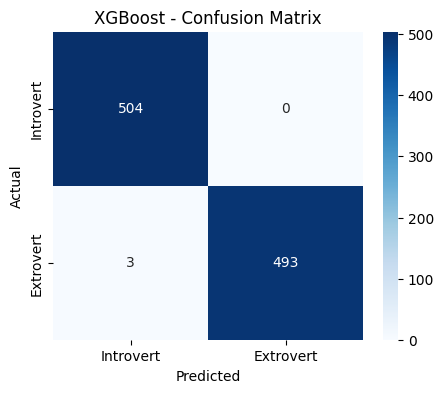

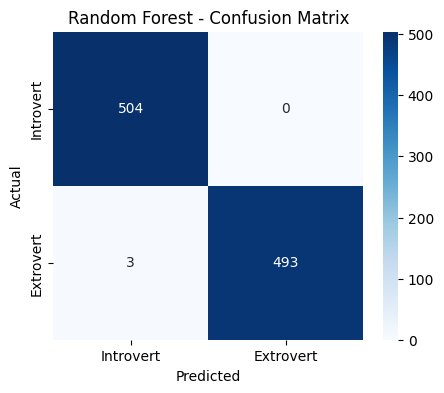

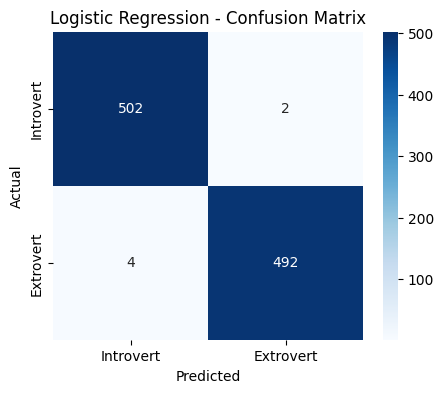

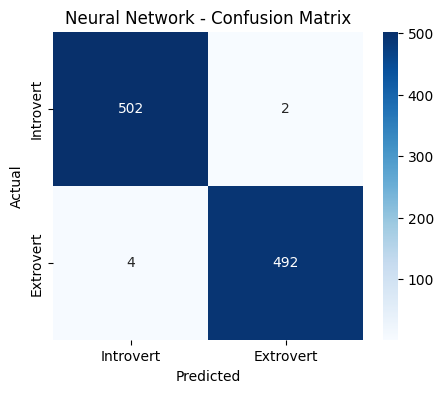

In [32]:
for name, preds in models.items():
    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Introvert', 'Extrovert'], yticklabels=['Introvert', 'Extrovert'])
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

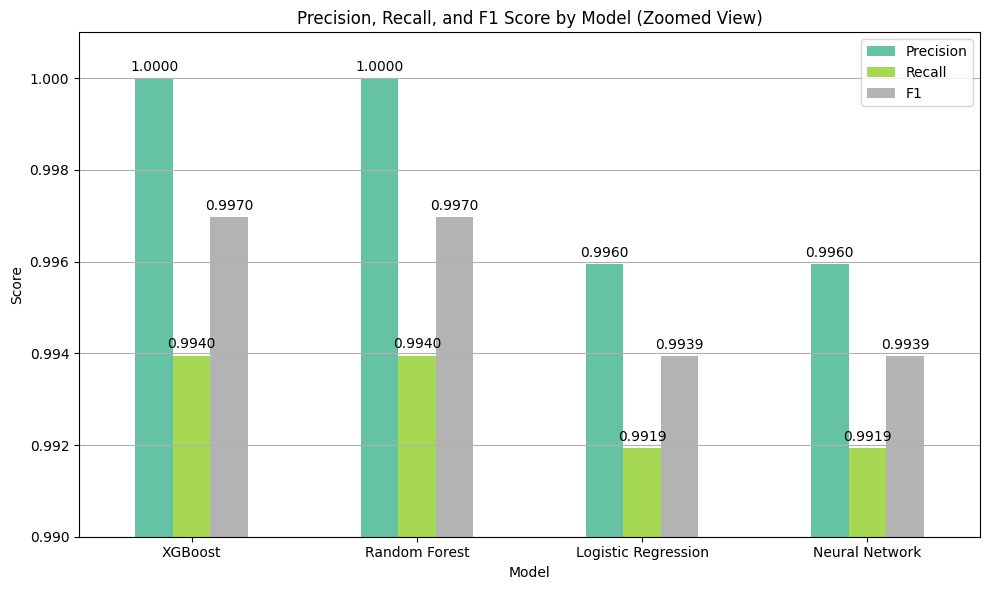

In [33]:
metrics_list = []
for name, preds in models.items():
    metrics_list.append({
        "Model": name,
        "Precision": precision_score(y_test, preds),
        "Recall": recall_score(y_test, preds),
        "F1": f1_score(y_test, preds)
    })
metrics_df = pd.DataFrame(metrics_list)
metrics_df.set_index("Model").plot(kind='bar', figsize=(10,6), colormap='Set2')
plt.title("Precision, Recall, and F1 Score by Model (Zoomed View)")
plt.ylabel("Score")
plt.ylim(0.99, 1.001)
plt.grid(True, axis='y')
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%.4f', label_type='edge', padding=3)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()